In [1]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import cv2 as cv
import time
import scipy.ndimage as img
# from picamera import PiCamera
# from picamera.array import PiRGBArray
from jupyterthemes import jtplot

In [2]:
# %matplotlib inline
plt.switch_backend('nbAgg')
jtplot.style()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## PiCam end

In [2]:
camera = PiCamera()

In [15]:
camera.resolution = (1280, 720)
camera.framerate = 15
camera.iso = 800
camera.shutter_speed = int(1/15 * 1e6)
rawCapture = PiRGBArray(camera, size=camera.resolution)
time.sleep(0.2)
for frame in camera.capture_continuous(rawCapture, format='bgr', use_video_port=True):
    image = frame.array
    cv.imshow('image', image)
    key = cv.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    
    if key -- ord('s'):
        cv.imwrite('double-0.04-0.50.png', image)
    if key == ord('q'):
        break
cv.destroyAllWindows()

In [35]:
cap = cv.VideoCapture('darkframe-iso800-30fps.h264')
count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if count == 0:
            dark = np.zeros_like(frame, float)
        if count >= 200:
            dark += frame
        count += 1
    else:
        break
dark /= 250
dark /= dark.max()
dark *= 255
dark = np.uint8(dark)
cap.release()
cv.imwrite('darkframe-iso800-30fps.png', dark)

True

## Computer end

In [7]:
class ApertureEstimator:
    def __init__(self, diff_pattern, dark_frame=None):
        self.diff_pattern = self._parse_input_images(diff_pattern)
        if dark_frame is not None:
            self.dark_frame = self._parse_input_images(dark_frame)
            if self.dark_frame.shape != self.diff_pattern.shape:
                self.dark_frame = cv.resize(self.dark_frame, self.diff_pattern.shape[::-1])
            self.diff_pattern -= self.dark_frame

    def _parse_input_images(self, parsee):
        if isinstance(parsee, str):
            return cv.imread(parsee, 0)
        elif isinstance(parsee, np.ndarray):
            return parsee
        else:
            raise TypeError('Input must be a filename or numpy array.')
            
    def showPattern(self, savename=None):
        plt.imshow(self.diff_pattern, 'gray')
        plt.grid(0)
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        
    def estimateAperture(self, logscale=False, savename=None):
        self.aperture = fft.fft2(self.diff_pattern)
        if logscale:
            plt.imshow(abs(np.log10(fft.fftshift(self.aperture))), 'gray')
        else:
            plt.imshow(abs(fft.fftshift(self.aperture)), 'gray')
        plt.grid(0)
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        
    def simulateAperture(slit_type, 
                         slit_width, 
                         slit_length, 
                         slit_separation=None, 
                         resolution=1024,
                         savename=None):
        slit_wid = slit_width
        slit_len = slit_length
        if slit_type == 'double':
            assert slit_separation is not None, \
                   'slit_separation must be specified when slit_type is `double`'
            slit_sep = slit_separation
        L = resolution
        
        plt.figure(figsize=(5*2, 5))

        plt.subplot(121)
        ape = np.zeros((L, L))
        if slit_type == 'double':
            ape[L//2-slit_len//2 : L//2+slit_len//2+1, 
                L//2-slit_sep//2-slit_wid//2 : L//2-slit_sep//2+slit_wid//2] = 1
            ape[L//2-slit_len//2 : L//2+slit_len//2+1, 
                L//2+slit_sep//2-slit_wid//2 : L//2+slit_sep//2+slit_wid//2] = 1
        plt.imshow(ape, 'gray')
        plt.axis('off')

        plt.subplot(122)
        FA = fft.fft2(ape)
        plt.imshow(abs(fft.fftshift(FA)), 'gray')
        plt.axis('off')

        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()

<IPython.core.display.Javascript object>


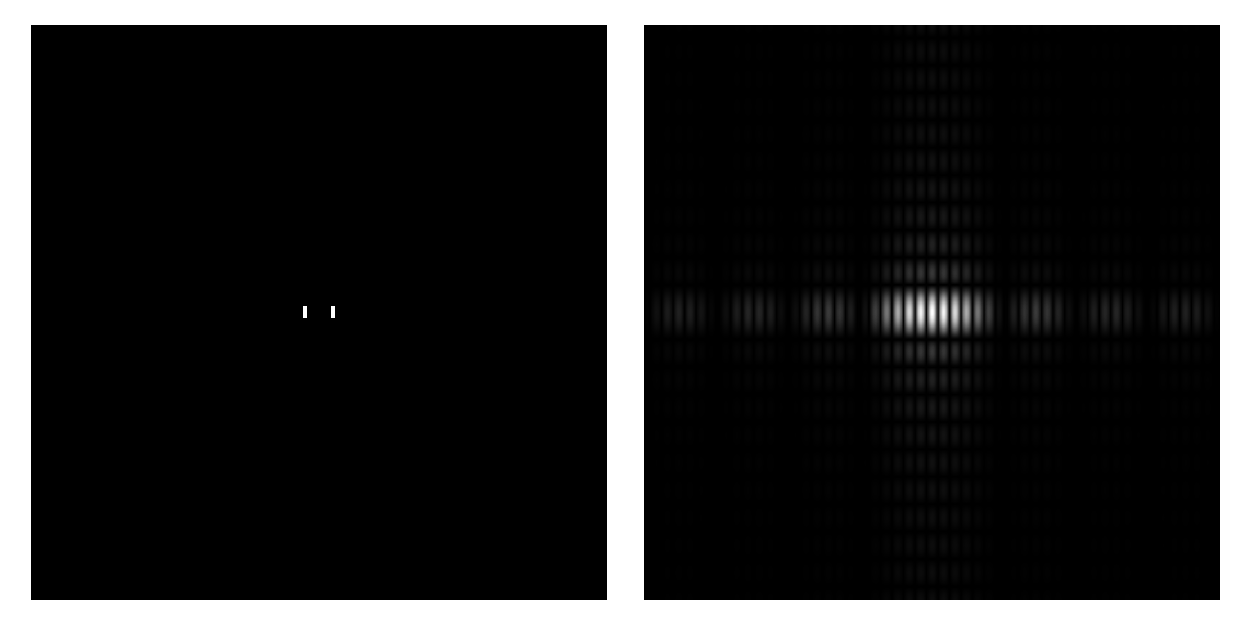

In [8]:
ApertureEstimator.simulateAperture('double', 8, 20, 50)

<IPython.core.display.Javascript object>


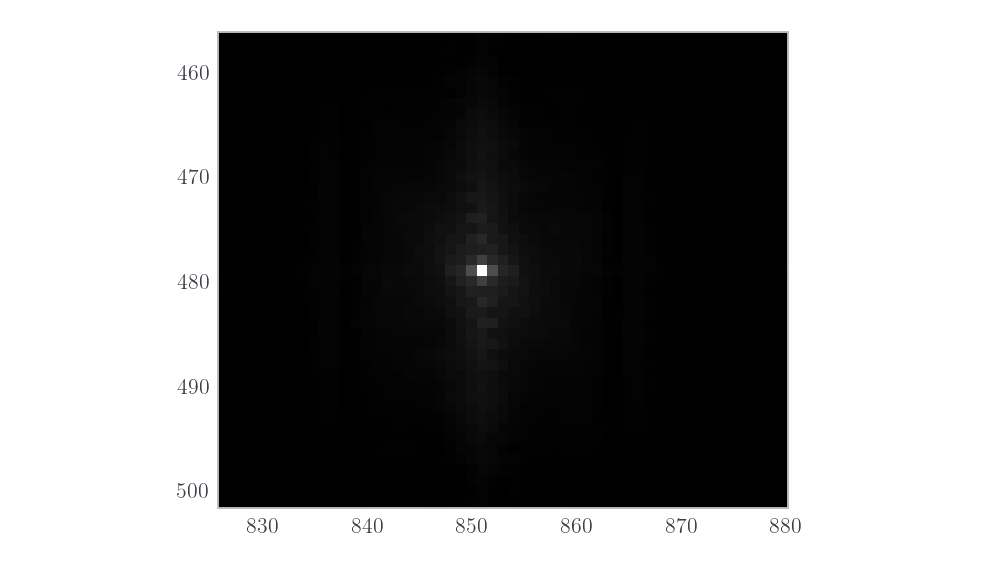

In [11]:
ae = ApertureEstimator('single-0.08.png', 'darkframe-iso800-30fps.png')
ae.showPattern()
ae.estimateAperture(logscale=False)